Notebook to generate semisynthetic CML data from a RADOLAN image and to reconstruct fields from this data using Random Mixing.

# Import

In [1]:
import os
import sys

fpth = os.path.abspath(os.path.join('..','RMWSPy', 'cml_example'))
sys.path.append(fpth)
fpth = os.path.abspath(os.path.join('..','RMWSPy', 'rmwspy'))
sys.path.append(fpth)

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns

import dask
from dask.distributed import Client
from dask_jobqueue import SLURMCluster

import sparse

# copied from pycomlink to aviod dowloading conflicting libraries
from grid_intersection import get_grid_time_series_at_intersections
from grid_intersection import calc_sparse_intersect_weights_for_several_cmls
from grid_intersection import calc_intersect_weights

import datetime
from tqdm import tqdm
import yaml

import rain_data as cmlp
import RM_processing as rmp
from cml import *

import CRPS.CRPS as pscore

%load_ext autoreload
%autoreload 2

In [2]:
erlend_pth = os.path.abspath(os.path.join('..','..'))
sys.path.append(erlend_pth)
from RM_processing import create_blocks_from_lines
from RM_processing import generate_cmls_grid_intersects

from scipy.stats import norm
import gstools as gs
import os, shutil
import string 
# supress warnings from shapely
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) 
import pickle

In [3]:
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as tkr
from matplotlib.ticker import FormatStrFormatter

In [4]:
from skgstat import Variogram

In [5]:
import poligrain

# prepare CML and rain gauge data

In [6]:
ds_rad = xr.open_dataset('./data/openMRG_example_rad.nc', engine='netcdf4')

In [7]:
# load radar data as processed in sandbox
ds_rad = xr.open_dataset('./data/openMRG_example_rad.nc').rename( # create using notebook in data folder
    {'rainfall':'rainfall_amount', # in mm/h
     'lat':'latitudes',
     'lon':'longitudes'
    }
).transpose('time', 'y', 'x')

grid_point_location='center' 

# flip to work in the grid intersection function, also convert to sum 5 min
ds_rad['latitudes'] = (('y', 'x'), np.flip(ds_rad.latitudes.values, axis = 0)) 
ds_rad['rainfall_amount'] = (('time', 'y', 'x'), np.flip(ds_rad.rainfall_amount.values*(5/60), axis = 1))



In [8]:
# read gauge data from CSV and store to xarray, copied from Graf compare article
df_gauge = pd.read_csv('/home/erlend/offline_data/andersson_2022_OpenMRG/gauges/city/CityGauges-2015JJA.csv',
                            index_col=0,
                           parse_dates=True
                           )
df_gauge_meta = pd.read_csv('/home/erlend/offline_data/andersson_2022_OpenMRG/gauges/city/CityGauges-metadata.csv')
 
ds_gauges = xr.Dataset(
    data_vars=dict(
        rainfall_amount=(["station_id", "time"], df_gauge.T),
    ),
    coords=dict(
        station_id=df_gauge_meta.index.values,
        time=df_gauge.index.values,
        lon=(["station_id"], df_gauge_meta.Longitude_DecDeg),
        lat=(["station_id"], df_gauge_meta.Latitude_DecDeg),
        location=(["station_id"], df_gauge_meta.Location),
        type=(["station_id"], df_gauge_meta.Type),
        quantization=(["station_id"], df_gauge_meta["Resolution (mm)"]),
    ),
)
# shorten and resample to sum 5 min
ds_gauges = ds_gauges.sel(time = slice(ds_rad.time[0], ds_rad.time[-1])).resample(time="5min").sum()

In [9]:
# read CML data
ds_cml = xr.open_dataset('./data/ds_cml_ompenmrg.nc').rename(
    {'site_0_lat':'site_a_latitude',
     'site_0_lon':'site_a_longitude',
     'site_1_lat':'site_b_latitude',
     'site_1_lon':'site_b_longitude',
    }
)

# shorten time span to match radar
ds_cml = ds_cml.sel(time = ds_rad.time)

# drop CMLs with nan, a bit restrictive but we have many CMLs here
ds_cml = ds_cml.where(~np.isnan(ds_cml.R).any(dim = 'time'), drop = True)

In [10]:
# shorten time
ds_cml = ds_cml.sel(time = slice('2015-07-25T12', '2015-07-25T15'))
ds_gauges = ds_gauges.sel(time = slice('2015-07-25T12', '2015-07-25T15'))
ds_rad = ds_rad.sel(time = slice('2015-07-25T12', '2015-07-25T15'))

In [11]:
# keep = np.where(ds_cml.length > 1500)[0]
# ds_cml = ds_cml.isel(cml_id = keep)

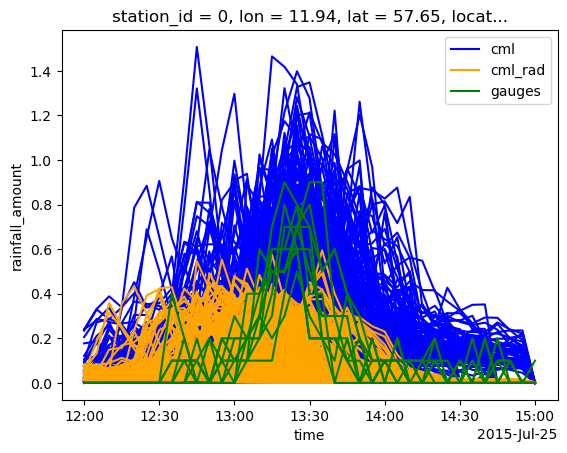

In [12]:
ds_cml.R.plot.line(x = 'time', add_legend= False, color = 'blue');
ds_cml.R.isel(cml_id = 0).plot.line(x = 'time', add_legend= False, color = 'blue', label = 'cml');

ds_cml.R_rad.plot.line(x = 'time', add_legend= False, color = 'orange');
ds_cml.R_rad.isel(cml_id = 0).plot.line(x = 'time', add_legend= False, color = 'orange', label = 'cml_rad');

ds_gauges.rainfall_amount.plot.line(x = 'time', add_legend= False, color = 'green');

ds_gauges.isel(station_id = 0).rainfall_amount.plot.line(x = 'time', add_legend= False, color = 'green', label = 'gauges');

plt.legend()

# Resample time

In [13]:
# resample to 5 min resolution to match gauge resolution
#ds_cml = ds_cml.resample(time = '15min').sum()
#ds_gauges = ds_gauges.resample(time = '15min').sum()
#ds_rad =  ds_rad.resample(time = '15min').sum()
# quickfix dimensions 
#ds_rad['crs'] = ds_rad.crs.isel(time = 0)
#ds_rad['latitudes'] = ds_rad.latitudes.isel(time = 0)
#ds_rad['longitudes'] = ds_rad.longitudes.isel(time = 0)

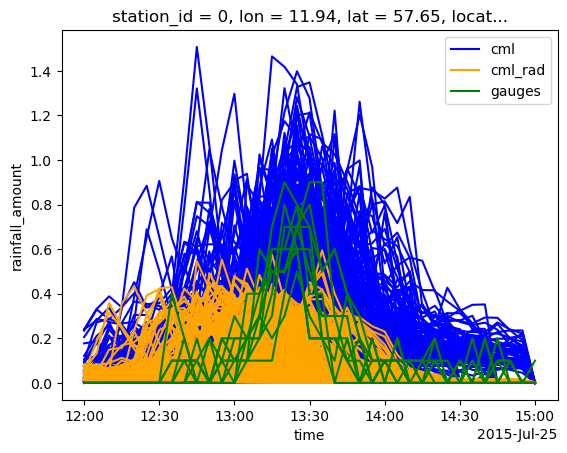

In [14]:
ds_cml.R.plot.line(x = 'time', add_legend= False, color = 'blue');
ds_cml.R.isel(cml_id = 0).plot.line(x = 'time', add_legend= False, color = 'blue', label = 'cml');

ds_cml.R_rad.plot.line(x = 'time', add_legend= False, color = 'orange');
ds_cml.R_rad.isel(cml_id = 0).plot.line(x = 'time', add_legend= False, color = 'orange', label = 'cml_rad');

ds_gauges.rainfall_amount.plot.line(x = 'time', add_legend= False, color = 'green');

ds_gauges.isel(station_id = 0).rainfall_amount.plot.line(x = 'time', add_legend= False, color = 'green', label = 'gauges');

plt.legend()

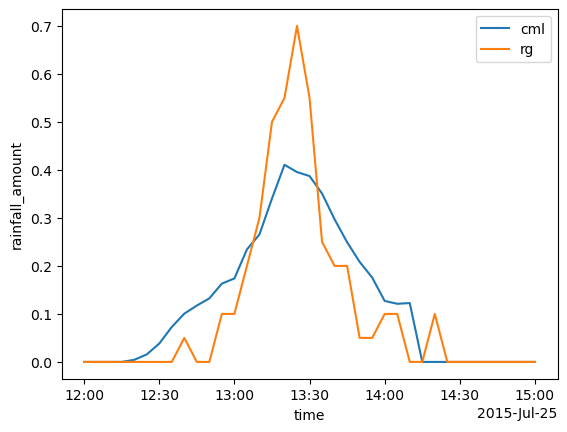

In [15]:
ds_cml.R.median(dim = 'cml_id').plot(label = 'cml')
ds_gauges.rainfall_amount.median(dim = 'station_id').plot(label = 'rg')
plt.legend()

# Use CML data in RM algorithm
Here I use the CML data in all steps. CML midpoints are used for the estimation of the spatial model, the transformation function, and (optional, see flag `linear_constraints`) as linear constraints. CML paths are still considered at the end as nonlinear constraints.

**Note that I remove several CMLs.** The reason is that it is not possible (singular matrix) to estimate the spatial model with observations on the same grid point. I remove them completely now, though it would be possible to use them as nonlinear constraints still.

In [16]:
# define options
lin_constraints = False             # whether linear constraints should be considered
nonlin_constraints = True           # whether nonlinear constraints should be considered
nfields = 4                         # number of ensemble members
maskR = None                        # special functionality with masking, should always be None here
outfolder = "../../data/fields/"    # path to output folder

In [17]:
from pyproj import CRS
from pyproj import Transformer

In [18]:
#ds_cml = xr.open_dataset("./data/cml_rain_from_rad.nc",)
#ds_rad = xr.open_dataset("./data/ds_rad.nc")

In [19]:
crs = CRS('EPSG:32632') # Norway: EPSG:32632, Sweden: 32633
crs_source = CRS('EPSG:4326') # latitude longitude wgs84

# Create Transformer to convert from geodetic CRS to CRS: https://pyproj4.github.io/pyproj/stable/examples.html
proj = Transformer.from_crs(crs_source, crs, always_xy=True)

In [20]:
site_a_x, site_a_y = proj.transform(ds_cml.site_a_longitude, ds_cml.site_a_latitude)
site_b_x, site_b_y = proj.transform(ds_cml.site_b_longitude, ds_cml.site_b_latitude)

ds_cml = ds_cml.assign_coords(x_a = ("cml_id", site_a_x))
ds_cml = ds_cml.assign_coords(y_a = ("cml_id", site_a_y))
ds_cml = ds_cml.assign_coords(x_b = ("cml_id", site_b_x))
ds_cml = ds_cml.assign_coords(y_b = ("cml_id", site_b_y))
                              
ds_cml = ds_cml.assign_coords(x = ("cml_id", np.mean([site_a_x.reshape(-1, 1), site_b_x.reshape(-1, 1)], axis = 0).ravel()))
ds_cml = ds_cml.assign_coords(y = ("cml_id", np.mean([site_a_y.reshape(-1, 1), site_b_y.reshape(-1, 1)], axis = 0).ravel()))

In [21]:
# convert gauges to cml coordinate system
gau_x, gau_y = proj.transform(ds_gauges.lon, ds_gauges.lat)
ds_gauges = ds_gauges.assign_coords(x = ("station_id", gau_x))
ds_gauges = ds_gauges.assign_coords(y = ("station_id", gau_y))

In [22]:
# create grid based on CML possitions:
offset = 500 # meter to the side
gridsize = 500 # meter per grid cell
xgrid = np.arange(np.min([ds_cml.x_a, ds_cml.x_b]) - offset, 
                  np.max([ds_cml.x_a, ds_cml.x_b]) + offset, gridsize).astype(int)
ygrid = np.arange(np.min([ds_cml.y_a, ds_cml.y_b]) - offset, 
                  np.max([ds_cml.y_a, ds_cml.y_b]) + offset, gridsize).astype(int)

# xgrid = np.arange(ds_gauges.x.min() - offset, ds_gauges.x.max() + offset, gridsize).astype(int)
# ygrid = np.arange(ds_gauges.y.min() - offset, ds_gauges.y.max() + offset, gridsize).astype(int)

In [23]:
ds_cml = ds_cml.where(ds_cml.x_a > xgrid[0], drop= True)
ds_cml = ds_cml.where(ds_cml.x_b > xgrid[0], drop= True)

ds_cml = ds_cml.where(ds_cml.x_a < xgrid[-1], drop= True)
ds_cml = ds_cml.where(ds_cml.x_b < xgrid[-1], drop= True)

ds_cml = ds_cml.where(ds_cml.y_a > ygrid[0], drop= True)
ds_cml = ds_cml.where(ds_cml.y_b > ygrid[0], drop= True)

ds_cml = ds_cml.where(ds_cml.y_a < ygrid[-1], drop= True)
ds_cml = ds_cml.where(ds_cml.y_b < ygrid[-1], drop= True)

In [24]:
# convert radar to cml coordinate system, assign value to closest xgrid value
rad_x, rad_y = proj.transform(ds_rad.longitudes, ds_rad.latitudes)

In [25]:
# array for storing transformed rainfall values, these are only used for visualization inside this notebook
rad_imgs = np.zeros([ds_rad.time.size, ygrid.size, xgrid.size])
cml_imgs = np.zeros([ds_rad.time.size, ygrid.size, xgrid.size])

for y_ind in tqdm(range(ygrid.size)):
    for x_ind in range(xgrid.size):
        # compute distances to all radar points
        distances_rad = (rad_x - xgrid[x_ind])**2 + (rad_y - ygrid[y_ind])**2
        
        # find possition of closes point in grid
        index = np.argmin(distances_rad) 
        y_rad_ind, x_rad_ind = np.unravel_index(index, distances_rad.shape)
        
        # compute distances to all CML midpoints
        distances_cml = np.argmin(((ds_cml.x - xgrid[x_ind])**2 + (ds_cml.y - ygrid[y_ind])**2).data)
        
        for t in range(ds_rad.time.size): #
            
            # get closest radar value for this point
            rad_imgs[t, y_ind, x_ind] = ds_rad.rainfall_amount.isel(time = t, y = y_rad_ind, x = x_rad_ind).values
            
            # get closest cml value for this point
            cml_imgs[t, y_ind, x_ind] = ds_cml.R.isel(time = t, cml_id = distances_cml).values            
            

ds_rad_proj = xr.Dataset(
        data_vars= dict(
            rainfall_amount=(['time', 'y', 'x'], rad_imgs), 
            cml_nearest = (['time', 'y', 'x'], cml_imgs), # nearest neighbour interpolation
        ),
        coords=dict(
            time = ds_rad.time,
            y = ygrid,
            x = xgrid
        ),
    ) 

100%|█████████████████████████████████████████| 145/145 [13:35<00:00,  5.62s/it]


In [26]:
ymin = ds_rad_proj.y.min().values 
xmin = ds_rad_proj.x.min().values
ymax = ds_rad_proj.y.max().values
xmax = ds_rad_proj.x.max().values

# domainsize defined by radolan image (ensure that y is first coordinate of rainfall amount)
domainsize = ds_rad_proj.rainfall_amount.shape

In [27]:
# shift radar: 
ds_rad_proj['y'] = ('y', ((ds_rad_proj.y.values - ymin)/gridsize).astype(int)) # convert to km to make it match indice
ds_rad_proj['x'] = ('x', ((ds_rad_proj.x.values - xmin)/gridsize).astype(int))

# shift gauges
ds_gauges["y"] = ((ds_gauges.y - ygrid[0])/gridsize).astype(int)
ds_gauges["x"] = ((ds_gauges.x - xgrid[0])/gridsize).astype(int)

In [28]:
# shift towards origin
# Now these variables represent both the indice and length between them, they can also be represented in RM? 
ds_cml["y_a"] = ((ds_cml.y_a - ygrid[0])/gridsize).astype(int)
ds_cml["x_a"] = ((ds_cml.x_a - xgrid[0])/gridsize).astype(int)
ds_cml["y_b"] = ((ds_cml.y_b - ygrid[0])/gridsize).astype(int)
ds_cml["x_b"] = ((ds_cml.x_b - xgrid[0])/gridsize).astype(int)

# set midpoint
ds_cml["x"] = ((ds_cml.x_a + ds_cml.x_b)/2).astype(int)
ds_cml["y"] = ((ds_cml.y_a + ds_cml.y_b)/2).astype(int)

In [29]:
# adjust naming conventions
ds_cml = ds_cml.rename({"cml_id": "obs_id"})

In [30]:
# remove observations that fall on the same grid point
ds_cml = cmlp.label_combined_duplicates(ds_cml)
ds_cml = ds_cml.where(ds_cml.label_dupl, drop=True)

# remove some cmls that also are duplicates
ds_cml['duplicate'] = np.logical_and( ds_cml.x_a == ds_cml.x_b, ds_cml.y_a == ds_cml.y_b)
ds_cml['duplicate'] = ds_cml['duplicate'] != 0 # 
ds_cml = ds_cml.where(ds_cml.duplicate == False, drop = True)

### Plot situation:

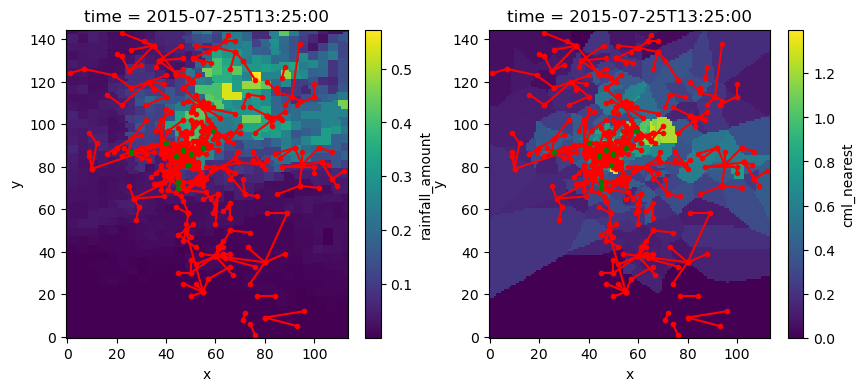

In [31]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))
ds_rad_proj.sel(time =  '2015-07-25T13:25', method = 'nearest').rainfall_amount.plot.imshow(ax = ax[0])
for device in ds_cml.obs_id:
    ax[0].plot([device.x_a, device.x_b],[
            device.y_a, device.y_b], '-r', marker='o', markersize =3)
    
for device in ds_gauges.station_id:
    ax[0].plot(device.x, device.y, 'g', marker='o', markersize =3)


ds_rad_proj.sel(time =  '2015-07-25T13:25', method = 'nearest').cml_nearest.plot.imshow(ax = ax[1])
for device in ds_cml.obs_id:
    ax[1].plot([device.x_a, device.x_b],[
            device.y_a, device.y_b], '-r', marker='o', markersize =3)
    
for device in ds_gauges.station_id:
    ax[1].plot(device.x, device.y, 'g', marker='o', markersize =3)

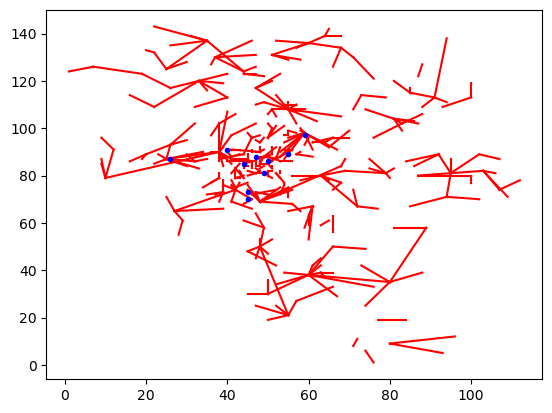

In [32]:
#ds_rad_proj.sel(time = '2015-07-25T13:25').cml_nearest.plot.imshow()
for device in ds_cml.obs_id:
    plt.plot([device.x_a, device.x_b],[
            device.y_a, device.y_b], '-r', marker='o', markersize =0.1)
    
for device in ds_gauges.station_id:
    plt.plot(device.x, device.y, 'blue', marker='o', markersize =3)

### Plot the variogram

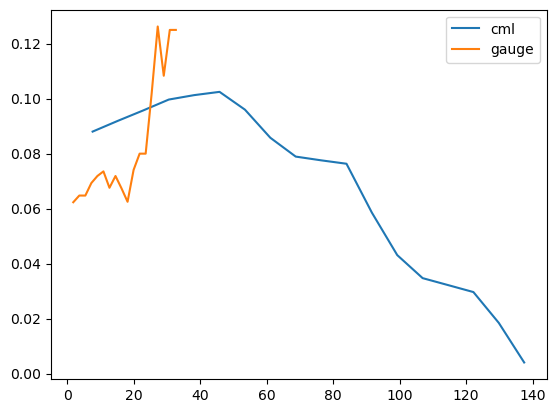

In [33]:
time = '2015-07-25T13:30'
cml_val = ds_cml.sel(time = time).R.values
dist_cml = np.sqrt((ds_cml.x.values - ds_cml.x.values.reshape(-1, 1))**2 + (ds_cml.y.values - ds_cml.y.values.reshape(-1, 1))**2).ravel()
var_cml = (0.5*(cml_val - cml_val.reshape(-1, 1))**2).ravel()

gauge_val = ds_gauges.sel(time = time).rainfall_amount.values
dist_gauge = np.sqrt((ds_gauges.x.values - ds_gauges.x.values.reshape(-1, 1))**2 + (ds_gauges.y.values - ds_gauges.y.values.reshape(-1, 1))**2).ravel()
var_gauge = (0.5*(gauge_val - gauge_val.reshape(-1, 1))**2).ravel()


bins = np.linspace(0, max(dist_cml), 20)
var_bin = []
for i in range(1, bins.size):
    in_bin = (dist_cml > bins[i-1]) & (dist_cml > bins[i])
    var_bin.append(var_cml[in_bin].mean())
plt.plot(bins[1:], var_bin, label = 'cml')

bins = np.linspace(0, max(dist_gauge), 20)
var_bin = []
for i in range(1, bins.size):
    in_bin = (dist_gauge > bins[i-1]) & (dist_gauge > bins[i])
    var_bin.append(var_gauge[in_bin].mean())
plt.plot(bins[1:], var_bin, label = 'gauge')
plt.legend()

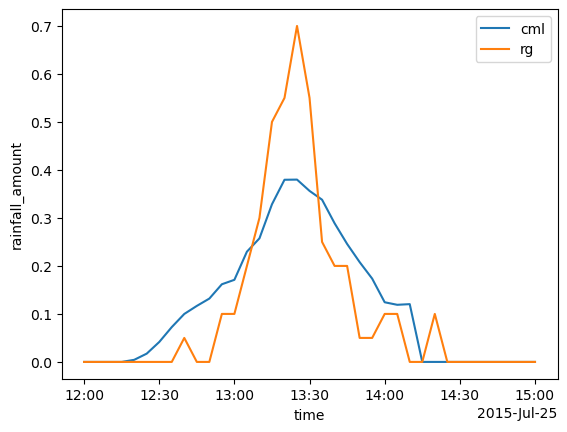

In [34]:
ds_cml.R.median(dim = 'obs_id').plot(label = 'cml')
ds_gauges.rainfall_amount.median(dim = 'station_id').plot(label = 'rg')
plt.legend()

In [35]:
from gcopula_sparaest import reconstruct_parameters

# Calculate correlation lengths for all timesteps

In [36]:
time_start = '2015-07-25T12:30' # 12:00
time_end = '2015-07-25T14:30' # 15:30
n_ests = 8# 8

### For rain gauges

In [59]:
n_ests = n_ests # use 8
cmod_midpoint_steps = {} # store data as timestep:[sim .. ]
cmod_eshelmidpoint_steps = {} # store data as timestep:[sim .. ]

seed = 4
np.random.seed(seed)
for time in tqdm(ds_cml.sel(time = slice(time_start, time_end)).time):
    cmod_midpoint_steps[time.values] = []
    cmod_eshelmidpoint_steps[time.values] = []

    for _ in range(n_ests):
        # Method 1: Midpoint
        # Calulate Copula model and marginal
        lin_yx = np.vstack((ds_gauges.sel(time = time).y.values, ds_gauges.sel(time = time).x.values)).T.astype(int)
        lin_prec = ds_gauges.sel(time = time).rainfall_amount.values
        keep = lin_prec > 0 # keep values larger than 0
        lin_prec = lin_prec[keep]
        lin_yx = lin_yx[keep, :]
        
        if (lin_prec.size > 2) and (np.unique(lin_prec).size > 1): # at least some observations..
            cmod_midpoint = rmp.calculate_copula( 
                lin_yx,
                lin_prec*10,
                outputfile=None,
                covmods='exp',
                ntries=5,
                nugget=0.001,
                maxrange = 600,
                minrange = 1,
            )
            cmod_midpoint_steps[time.values].append(cmod_midpoint)

            # method 2

            V = Variogram(
                np.hstack([lin_yx[:, 1].reshape(-1, 1), lin_yx[:, 0].reshape(-1, 1)]), 
                np.log(lin_prec), # log transform to make data more gaussian
                model='exponential', 
                use_nugget=False,
                fit_bounds = ((1, 0), (600, np.log(lin_prec).var()*2)),
            )
            hr, sill, nugget = V.parameters
            hr = hr/3
            # store as RM variogram
            cmod_eshelmidpoint_steps[time.values].append('0.001 Nug(0.0) + 0.999 Exp('+ str(round(hr, 3)) + ')')
            
        else:
            cmod_midpoint_steps[time.values].append(np.nan)
            cmod_eshelmidpoint_steps[time.values].append(np.nan)

# get estimated range (for plotting)
cmod_midpoint_plot = {}
cmod_eshelmidpoint_plot = {}
for time in tqdm(ds_cml.sel(time = slice(time_start, time_end)).time):
    cmod_midpoint_plot[time.values] = []
    cmod_eshelmidpoint_plot[time.values] = []
    for i in range(n_ests):
        if pd.isnull(cmod_midpoint_steps[time.values][i]):
            cmod_midpoint_plot[time.values].append(np.nan)
            cmod_eshelmidpoint_plot[time.values].append(np.nan)
        else:
            cmod_midpoint_plot[time.values].append(float(cmod_midpoint_steps[time.values][i].split()[-1][4:-1]))
            cmod_eshelmidpoint_plot[time.values].append(float(cmod_eshelmidpoint_steps[time.values][i].split()[-1][4:-1]))
            
df_midpoint_rg = pd.DataFrame(cmod_midpoint_plot).T
df_eshelmidpoint_rg = pd.DataFrame(cmod_eshelmidpoint_plot).T


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 1931.22it/s]


### For all links

In [40]:
n_ests = 2 # use 8
cmod_midpoint_steps = {} # store data as timestep:[sim .. ]
cmod_dereg_steps = {}
cmod_eshelmidpoint_steps = {}
cmod_esheldereg_steps = {}
L = np.sqrt((ds_cml.y_a - ds_cml.y_b)**2 + (ds_cml.x_a - ds_cml.x_b)**2).mean().data

seed = 4
np.random.seed(seed)
for time in tqdm(ds_cml.sel(time = slice(time_start, time_end)).time):
    cmod_midpoint_steps[time.values] = []
    cmod_dereg_steps[time.values] = []
    cmod_eshelmidpoint_steps[time.values] = []
    cmod_esheldereg_steps[time.values] = []
    for _ in range(n_ests):
        # Method 1: Midpoint
        # Calulate Copula model and marginal
        lin_yx = np.vstack((ds_cml.sel(time = time).y.values, ds_cml.sel(time = time).x.values)).T.astype(int)
        lin_prec = ds_cml.sel(time = time).R.values
        keep = lin_prec > 0 # keep values larger than 0
        lin_prec = lin_prec[keep]
        lin_yx = lin_yx[keep, :]
        
        if (lin_prec.size > 2) and (np.unique(lin_prec).size > 1): # at least some observations..
            lin_yx = np.vstack((ds_cml.sel(time = time).y.values, ds_cml.sel(time = time).x.values)).T.astype(int)
            lin_prec = ds_cml.sel(time = time).R.values
            keep = lin_prec > 0 # keep values larger than 0
            lin_prec = lin_prec[keep]
            lin_yx = lin_yx[keep, :]

            #ind = np.random.choice(lin_yx.shape[0], size=20, replace=False)
            ind = np.arange(0, lin_yx.shape[0]) # select all
            cmod_midpoint = rmp.calculate_copula( 
                lin_yx[ind, :],
                lin_prec[ind]*10,
                outputfile=None,
                covmods='exp', 
                ntries=5,
                nugget=0,
                maxrange = 600,
                minrange = 1,
            )
            cmod_midpoint_steps[time.values].append(cmod_midpoint)

            # Prepare data for method 2 dereg.
            # create geometry and fit copula model
            pos_x, pos_y = create_blocks_from_lines(np.hstack([
                ds_cml.sel(time = time).y_a.values.reshape(-1, 1),
                ds_cml.sel(time = time).y_b.values.reshape(-1, 1),
                ds_cml.sel(time = time).x_a.values.reshape(-1, 1),
                ds_cml.sel(time = time).x_b.values.reshape(-1, 1),
                ]), disc = 8)
            cml_yx_block = np.array([pos_y, pos_x]).transpose([1, 0, 2])
            cml_yx_block = cml_yx_block[keep]
            
            cmod_dereg = rmp.calculate_copula(
                cml_yx_block[ind, :],
                lin_prec[ind]*10,
                outputfile=None,
                covmods="exp",
                ntries=5,
                nugget=0.001,
                #nugget=float(cmod_midpoint.split('p')[0][0:5]),
                mode='block',
                maxrange = float(cmod_midpoint.split('p')[-1][1:-3]),
                minrange = 1, # 1/4 the below grid size
            )
            cmod_dereg_steps[time.values].append(cmod_dereg)

            # Eshel
            lin_yx = np.vstack((ds_cml.sel(time = time).y.values, ds_cml.sel(time = time).x.values)).T.astype(int)
            lin_prec = ds_cml.sel(time = time).R.values
            lin_yx, lin_prec = cmlp.filter_nans_a(lin_yx, lin_prec)
            keep = lin_prec > 0 # keep values larger than 0
            lin_prec = lin_prec[keep]
            lin_yx = lin_yx[keep, :]
            V = Variogram(
                np.hstack([lin_yx[:, 1].reshape(-1, 1), lin_yx[:, 0].reshape(-1, 1)]), 
                np.log(lin_prec), # log transform to make data more gaussian
                model='exponential', 
                use_nugget=False,
                fit_bounds = ((1, 0), (600, np.log(lin_prec).var()*2)),
            )
            hr, sill, nugget = V.parameters
            hr = hr/3
            # store as RM variogram
            cmod_eshelmidpoint_steps[time.values].append('0.001 Nug(0.0) + 0.999 Exp('+ str(round(hr, 3)) + ')')
            cmod_esheldereg_steps[time.values].append('0.001 Nug(0.0) + 0.999 Exp('+ str(round(hr - 0.72*(1*L)**0.72, 3)) + ')')
            
        else:
            cmod_midpoint_steps[time.values].append(np.nan)
            cmod_dereg_steps[time.values].append(np.nan)
            cmod_eshelmidpoint_steps[time.values].append(np.nan)
            cmod_esheldereg_steps[time.values].append(np.nan)
            
# get estimated range (for plotting)
cmod_midpoint_plot = {}
cmod_dereg_plot = {}
cmod_eshelmidpoint_plot = {}
cmod_esheldereg_plot = {}

for time in tqdm(ds_cml.sel(time = slice(time_start, time_end)).time):
    cmod_midpoint_plot[time.values] = []
    cmod_dereg_plot[time.values] = []
    cmod_eshelmidpoint_plot[time.values] = []
    cmod_esheldereg_plot[time.values] = []
    for i in range(n_ests):
        if pd.isnull(cmod_midpoint_steps[time.values][i]):
            cmod_midpoint_plot[time.values].append(np.nan)
            cmod_dereg_plot[time.values].append(np.nan)
            cmod_eshelmidpoint_plot[time.values].append(np.nan)
            cmod_esheldereg_plot[time.values].append(np.nan)
        else:
            cmod_midpoint_plot[time.values].append(float(cmod_midpoint_steps[time.values][i].split()[-1][4:-1]))
            cmod_dereg_plot[time.values].append(float(cmod_dereg_steps[time.values][i].split()[-1][4:-1]))
            cmod_eshelmidpoint_plot[time.values].append(float(cmod_eshelmidpoint_steps[time.values][i].split()[-1][4:-1]))
            cmod_esheldereg_plot[time.values].append(float(cmod_esheldereg_steps[time.values][i].split()[-1][4:-1]))
            
df_dereg = pd.DataFrame(cmod_dereg_plot).T
df_midpoint = pd.DataFrame(cmod_midpoint_plot).T
df_eshelmidpoint = pd.DataFrame(cmod_eshelmidpoint_plot).T
df_esheldereg = pd.DataFrame(cmod_esheldereg_plot).T


100%|█████████████████████████████████████████| 25/25 [00:00<00:00, 1115.46it/s]


(0.0, 80.0)

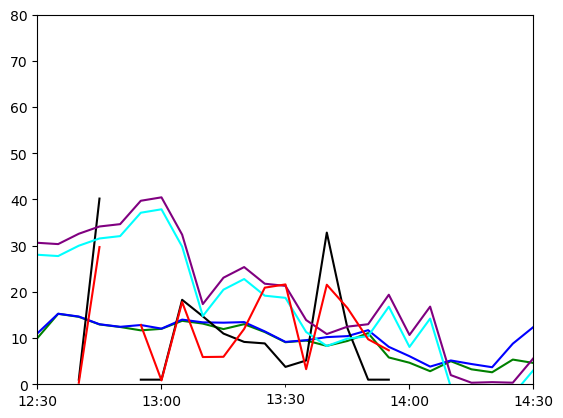

In [60]:
df_dereg.mean(axis = 1).rolling(
    window = 1, center = True, min_periods=1).mean().plot(color = 'green', linestyle= '-')

df_midpoint.mean(axis = 1).rolling(
    window = 1, center = True, min_periods=1).mean().plot(color = 'blue', linestyle= '-')

df_midpoint_rg.mean(axis = 1).rolling(
    window = 1, center = True, min_periods=1).mean().plot(color = 'black', linestyle= '-')

df_eshelmidpoint.mean(axis = 1).rolling(
    window = 1, center = True, min_periods=1).mean().plot(color = 'purple', linestyle= '-')

df_esheldereg.mean(axis = 1).rolling(
    window = 1, center = True, min_periods=1).mean().plot(color = 'cyan', linestyle= '-')

df_eshelmidpoint_rg.mean(axis = 1).rolling(
    window = 1, center = True, min_periods=1).mean().plot(color = 'red', linestyle= '-')
plt.ylim(0, 80)

In [61]:
# # # uncomment to save again
fields_5min = [df_dereg, df_midpoint, df_midpoint_rg, df_eshelmidpoint, df_esheldereg, df_eshelmidpoint_rg]
with open('/home/erlend/Downloads/fields_openmrg_variograms_mlp.pickle', 'wb') as handle:
    pickle.dump(fields_5min, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [37]:
# run top part of notebook (sample CMLs etc) before running this
with open(r'/home/erlend/Downloads/fields_openmrg_variograms_mlp.pickle', "rb") as input_file: 
    [df_dereg, df_midpoint, df_midpoint_rg, df_eshelmidpoint, df_esheldereg, df_eshelmidpoint_rg] = pickle.load(input_file)

# Condition stochastic fields for all timesteps:

In [38]:
nfields = 100 # number of fields to generate
N = 70 # number of samples from conditioned fields and real field 
N_samples = 8 # number of random fields to estimate from (must be lower than nfields)

synthetic_gridsize_yx = domainsize[1:]
time_iterate = ds_cml.sel(time = slice(time_start, time_end)).time

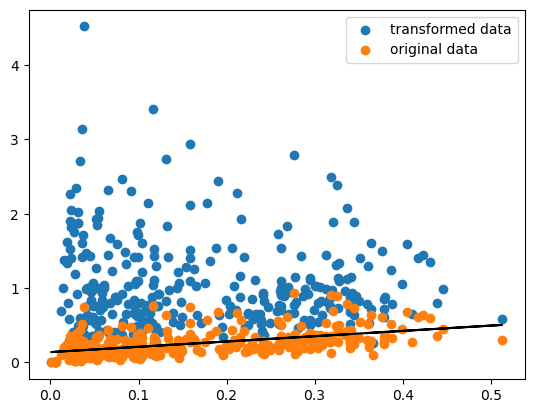

In [39]:
# RandomMixing with external drift:
# 1. Fit a linear model to CML vs Radar_at_cml data. 
# 2. Divide all CML data by this model (line as a function of radar) 
#    to obtain transformed CML data. Here the expected value is equal 
#    at all locations. 
# 3. Do random mixing on the transformed CML data. 
# 4. Backtransform resulting fields by multiplying by the linear 
#    model fit in 1. 

time = time_iterate[7]

data_cml = ds_cml.sel(time = time).R
data_rad = ds_cml.sel(time = time).R_rad

# Fit a line
slope, intercept = np.polyfit(data_rad, data_cml, 1)
plt.plot(data_rad, slope * data_rad + intercept, 'k')

# Transformed data:
transformed_cml = data_cml/(slope * data_rad + intercept)

plt.scatter(
    data_rad,
    transformed_cml,
    label = 'transformed data'
)

plt.scatter(
    data_rad,
    data_cml,
    label = 'original data'
)
plt.legend()

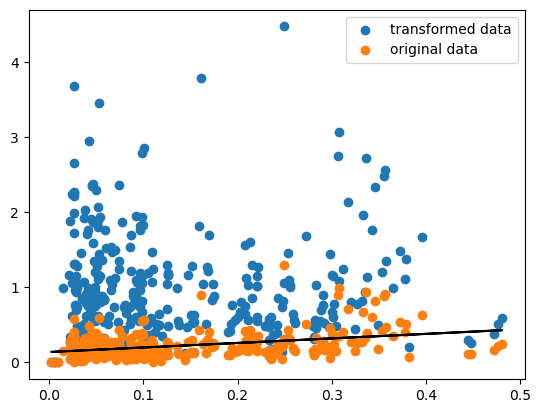

In [40]:
# RandomMixing with external drift:
# 1. Fit a linear model to CML vs Radar_at_cml data. 
# 2. Divide all CML data by this model (line as a function of radar) 
#    to obtain transformed CML data. Here the expected value is equal 
#    at all locations. 
# 3. Do random mixing on the transformed CML data. 
# 4. Backtransform resulting fields by multiplying by the linear 
#    model fit in 1. 

time = time_iterate[6]
time_rad = time_iterate[6]

data_cml = ds_cml.sel(time = time).R
data_rad = ds_cml.sel(time = time_rad).R_rad

# Fit a line
slope, intercept = np.polyfit(data_rad, data_cml, 1)
plt.plot(data_rad, slope * data_rad + intercept, 'k')

# Transformed data:
transformed_cml = data_cml/(slope * data_rad + intercept)

plt.scatter(
    data_rad,
    transformed_cml,
    label = 'transformed data'
)

plt.scatter(
    data_rad,
    data_cml,
    label = 'original data'
)
plt.legend()

In [63]:
# Condition and evaluate fields DEREG-DRIFT METHOD
copula_dereg_drift = {'gaussian_range_unconditioned': [], 'gaussian_range_conditioned': [], 'field_conditioned': []}
seed = 1
for time in time_iterate:
    if np.isnan(df_midpoint.loc[time.values]).any():
        copula_dereg_drift['gaussian_range_conditioned'].append(np.zeros(N_samples)*np.nan)
        copula_dereg_drift['field_conditioned'].append(
            np.zeros([nfields, synthetic_gridsize_yx[0], synthetic_gridsize_yx[1]])*np.nan) 
    else: 
        cml_prec = ds_cml.sel(time = time).R.values.ravel()
        rad_prec = ds_cml.sel(time = time).R_rad.data.ravel()
        
        # Fit a line
        slope, intercept = np.polyfit(rad_prec, cml_prec, 1)
        
        # Transformed data:
        cml_prec_t = cml_prec/(slope*rad_prec + intercept)

        # create nonlinear integrals for RM
        cml_yx = np.vstack(
            (
                ds_cml.sel(time = time).y_a.values,
                ds_cml.sel(time = time).x_a.values,
                ds_cml.sel(time = time).y_b.values,
                ds_cml.sel(time = time).x_b.values,
            )
        ).T.astype(int)
        cml_yx, cml_prec_t = cmlp.filter_nans_a(cml_yx, cml_prec_t)
        marginal = rmp.calculate_marginal(cml_prec_t*10) 

        # load estimated model, here use mean of all estimates
        cmod = '0.001 Nug(0.0) + 0.999 Exp(' + str(df_dereg.loc[time.values].mean()) + ')'

        # condition fields
        nonlin_integrals = rmp.nl_integrals(cml_yx) 
        my_CMLModel = CMLModel(cml_prec_t, marginal, nonlin_integrals)

        CS = RMWS(
            my_CMLModel,
            domainsize=synthetic_gridsize_yx,
            covmod=cmod,
            nFields=nfields,
            cp=None,
            cv=None,
            le_cp=None,
            le_cv=None,
            optmethod="circleopt",
            minObj=0.4,
            maxbadcount=30,
            maxiter=100,
            pyfftwmode=True,
            seed=seed,
            tstep="aaa",
        )
        CS()
        final_fields = rmp.backtransform(CS.finalFields, marginal)
        del CS

        # Get radar field for this timestep:
        rad_t = ds_rad_proj.rainfall_amount.sel(time = time).data

        # backtransform simulated fields using radar and model:
        final_fields = final_fields*(slope*rad_t + intercept)

        # Store resulting fields
        copula_dereg_drift['field_conditioned'].append(final_fields)     
    print(time.values)


2015-07-25T12:30:00.000000000
2015-07-25T12:35:00.000000000
2015-07-25T12:40:00.000000000
2015-07-25T12:45:00.000000000
2015-07-25T12:50:00.000000000
2015-07-25T12:55:00.000000000
2015-07-25T13:00:00.000000000
2015-07-25T13:05:00.000000000
2015-07-25T13:10:00.000000000
2015-07-25T13:15:00.000000000
2015-07-25T13:20:00.000000000
2015-07-25T13:25:00.000000000
2015-07-25T13:30:00.000000000
2015-07-25T13:35:00.000000000
2015-07-25T13:40:00.000000000
2015-07-25T13:45:00.000000000
2015-07-25T13:50:00.000000000
2015-07-25T13:55:00.000000000
2015-07-25T14:00:00.000000000
2015-07-25T14:05:00.000000000
2015-07-25T14:10:00.000000000
2015-07-25T14:15:00.000000000
2015-07-25T14:20:00.000000000
2015-07-25T14:25:00.000000000
2015-07-25T14:30:00.000000000


In [64]:
# Condition and evaluate fields DEREG METHOD
copula_dereg = {'gaussian_range_unconditioned': [], 'gaussian_range_conditioned': [], 'field_conditioned': []}
seed = 1
for time in time_iterate:
    if np.isnan(df_midpoint.loc[time.values]).any():
        copula_dereg['gaussian_range_conditioned'].append(np.zeros(N_samples)*np.nan)
        copula_dereg['field_conditioned'].append(
            np.zeros([nfields, synthetic_gridsize_yx[0], synthetic_gridsize_yx[1]])*np.nan) 
    else: 
        cml_prec = ds_cml.sel(time = time).R.values.ravel()

        # create nonlinear integrals for RM
        cml_yx = np.vstack(
            (
                ds_cml.sel(time = time).y_a.values,
                ds_cml.sel(time = time).x_a.values,
                ds_cml.sel(time = time).y_b.values,
                ds_cml.sel(time = time).x_b.values,
            )
        ).T.astype(int)
        cml_yx, cml_prec = cmlp.filter_nans_a(cml_yx, cml_prec)
        marginal = rmp.calculate_marginal(cml_prec*10) # 

        # load estimated model, here use mean of all estimates
        cmod = '0.001 Nug(0.0) + 0.999 Exp(' + str(df_dereg.loc[time.values].mean()) + ')'

        # condition fields
        nonlin_integrals = rmp.nl_integrals(cml_yx) 
        my_CMLModel = CMLModel(cml_prec, marginal, nonlin_integrals)

        CS = RMWS(
            my_CMLModel,
            domainsize=synthetic_gridsize_yx,
            covmod=cmod,
            nFields=nfields,
            cp=None,
            cv=None,
            le_cp=None,
            le_cv=None,
            optmethod="circleopt",
            minObj=0.4,
            maxbadcount=30,
            maxiter=100,
            pyfftwmode=True,
            seed=seed,
            tstep="aaa",
        )
        CS()
        final_fields = rmp.backtransform(CS.finalFields, marginal)
        del CS
        
        copula_dereg['field_conditioned'].append(final_fields)     
    print(time.values)


2015-07-25T12:30:00.000000000
2015-07-25T12:35:00.000000000
2015-07-25T12:40:00.000000000
2015-07-25T12:45:00.000000000
2015-07-25T12:50:00.000000000
2015-07-25T12:55:00.000000000
2015-07-25T13:00:00.000000000
2015-07-25T13:05:00.000000000
2015-07-25T13:10:00.000000000
2015-07-25T13:15:00.000000000
2015-07-25T13:20:00.000000000
2015-07-25T13:25:00.000000000
2015-07-25T13:30:00.000000000
2015-07-25T13:35:00.000000000
2015-07-25T13:40:00.000000000
2015-07-25T13:45:00.000000000
2015-07-25T13:50:00.000000000
2015-07-25T13:55:00.000000000
2015-07-25T14:00:00.000000000
2015-07-25T14:05:00.000000000
2015-07-25T14:10:00.000000000
2015-07-25T14:15:00.000000000
2015-07-25T14:20:00.000000000
2015-07-25T14:25:00.000000000
2015-07-25T14:30:00.000000000


In [65]:
# # # uncomment to save again
fields_5min = [copula_dereg_drift, copula_dereg]
with open('/home/erlend/Downloads/fields_openmrg_mlp.pickle', 'wb') as handle:
    pickle.dump(fields_5min, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [66]:
# rerun with scaled to radar external drift. 

In [41]:
# run top part of notebook (sample CMLs etc) before running this
with open(r'/home/erlend/Downloads/fields_openmrg_mlp.pickle', "rb") as input_file: 
    [copula_dereg_drift, copula_dereg] = pickle.load(input_file)

In [42]:
copula_dereg_drift['field_conditioned'] = np.array(copula_dereg_drift['field_conditioned'])
copula_dereg['field_conditioned'] = np.array(copula_dereg['field_conditioned'])

copula_dereg_drift['gaussian_range_conditioned'] = np.array(copula_dereg_drift['gaussian_range_conditioned'])
copula_dereg['gaussian_range_conditioned'] = np.array(copula_dereg['gaussian_range_conditioned'])


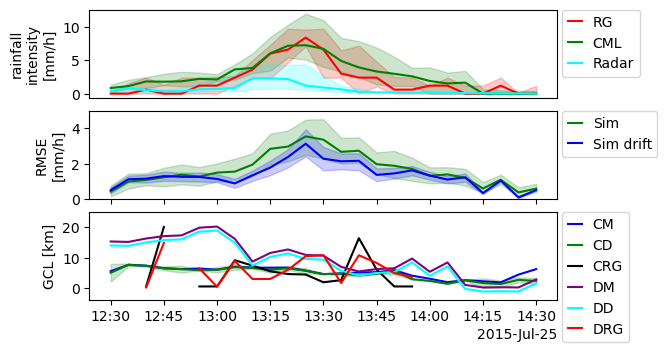

In [43]:
time_plot_start = '2015-07-25T12:30' #13.30
time_plot_end =   '2015-07-25T15:00' # 17.30
to_mmh = 12

time_t1 = np.argmax((time_iterate == time_iterate.sel(time = time_plot_start, method = 'nearest')).values)
time_t2 = np.argmax((time_iterate == time_iterate.sel(time = time_plot_end, method = 'nearest')).values) + 1 #(to include last timestep)
time_plot = time_iterate.sel(time =slice(time_plot_start, time_plot_end))


fig, ax = plt.subplots(3, 1,figsize =(6.5, 3.5), sharex = True)
plt.subplots_adjust(left=0.12, right=0.84, bottom=0.15, top=0.98, wspace=0.1, hspace=0.15)

# Mean ammounts
# Raingauges
mean = ds_gauges.sel(time = time_plot).rainfall_amount.median(dim = 'station_id').values*to_mmh
upper =  ds_gauges.sel(time = time_plot).rainfall_amount.quantile(q = 0.9, dim = 'station_id').values*to_mmh
lower =  ds_gauges.sel(time = time_plot).rainfall_amount.quantile(q = 0.1, dim = 'station_id').values*to_mmh
ax[0].plot(time_plot, mean, label='RG', color = 'red')
ax[0].fill_between(time_plot, lower, upper, color= 'red', alpha = 0.2)

# CML nearest
mean = np.median(ds_rad_proj.sel(time = time_plot).cml_nearest.data[time_t1:time_t2, ds_gauges.y.data, ds_gauges.x.data]*to_mmh, axis = 1)
upper = np.quantile(ds_rad_proj.sel(time = time_plot).cml_nearest.data[time_t1:time_t2, ds_gauges.y.data, ds_gauges.x.data]*to_mmh, axis = 1, q = 0.9)
lower = np.quantile(ds_rad_proj.sel(time = time_plot).cml_nearest.data[time_t1:time_t2, ds_gauges.y.data, ds_gauges.x.data]*to_mmh, axis = 1, q = 0.1)

ax[0].plot(time_plot, mean, label='CML', color = 'green')
ax[0].fill_between(time_plot, lower, upper, color= 'green', alpha = 0.2)

# Radar 
mean = ds_rad_proj.sel(time = time_plot).isel(y = ds_gauges.y.data, x = ds_gauges.x.data).median(dim = ('x', 'y')).rainfall_amount.data*to_mmh
upper = ds_rad_proj.sel(time = time_plot).isel(y = ds_gauges.y.data, x = ds_gauges.x.data).rainfall_amount.quantile(q = 0.9, dim = ('x', 'y')).data*to_mmh
lower = ds_rad_proj.sel(time = time_plot).isel(y = ds_gauges.y.data, x = ds_gauges.x.data).rainfall_amount.quantile(q = 0.1, dim = ('x', 'y')).data*to_mmh
ax[0].plot(time_plot, mean, label='Radar', color = 'cyan')
ax[0].fill_between(time_plot, lower, upper, color= 'cyan', alpha = 0.2)

# Labels etc. 
ax[0].tick_params(axis='x', which='both', bottom=False, top=False,labelbottom=False) 
ax[0].set_ylabel('rainfall\nintensity\n[mm/h]', fontsize=10)
ax[0].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, handlelength=1)


# MSE raingauges
pred_cml = copula_dereg['field_conditioned'][time_t1:time_t2, :, ds_gauges.y.data, ds_gauges.x.data]*to_mmh
ground = ds_gauges.sel(time = time_plot).rainfall_amount.data*to_mmh
ground = np.repeat(ground[:, np.newaxis, :], pred_cml.shape[1], axis=1) # repeat ground obs
mse = np.mean(np.sqrt((pred_cml - ground)**2), axis = 2)
mean = np.mean(mse, axis = 1)
upper = np.quantile(mse, axis = 1, q = 0.9)
lower = np.quantile(mse, axis = 1, q = 0.1)
ax[1].plot(time_plot, mean, label='Sim', color = 'green')
ax[1].fill_between(time_plot, lower, upper, color= 'green', alpha = 0.2)


pred_cml = copula_dereg_drift['field_conditioned'][time_t1:time_t2, :, ds_gauges.y.data, ds_gauges.x.data]*to_mmh
ground = ds_gauges.sel(time = time_plot).rainfall_amount.data*to_mmh
ground = np.repeat(ground[:, np.newaxis, :], pred_cml.shape[1], axis=1) # repeat ground obs
mse = np.mean(np.sqrt((pred_cml - ground)**2), axis = 2)
mean = np.mean(mse, axis = 1)
upper = np.quantile(mse, axis = 1, q = 0.9)
lower = np.quantile(mse, axis = 1, q = 0.1)
ax[1].plot(time_plot, mean, label='Sim drift', color = 'blue')
ax[1].fill_between(time_plot, lower, upper, color= 'blue', alpha = 0.2)

ax[1].set_xlabel('')
ax[1].set_ylabel('RMSE\n[mm/h]', fontsize=10)
ax[1].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, handlelength=1, fontsize=10)
ax[1].set_ylim(0, 5)


# gaussian correlation length, 
mid_plot = df_midpoint.loc[time_plot_start:time_plot_end]*(gridsize/1000)
mid_plot_rg = df_midpoint_rg.loc[time_plot_start:time_plot_end]*(gridsize/1000)
dereg_plot = df_dereg.loc[time_plot_start:time_plot_end]*(gridsize/1000)
eshelmid_plot = df_eshelmidpoint.loc[time_plot_start:time_plot_end]*(gridsize/1000)
esheldereg_plot = df_esheldereg.loc[time_plot_start:time_plot_end]*(gridsize/1000)
esheltrue_plot = df_eshelmidpoint_rg.loc[time_plot_start:time_plot_end]*(gridsize/1000)

mid_plot.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'CM', color = 'blue')
dereg_plot.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'CD', color = 'green')
mid_plot_rg.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'CRG', color = 'black')
eshelmid_plot.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'DM', color = 'purple')
esheldereg_plot.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'DD', color = 'cyan')
esheltrue_plot.mean(axis = 1).to_xarray().plot(ax=ax[2], label = 'DRG', color = 'red')


ax[2].fill_between(time_plot, dereg_plot.mean(axis = 1).values - dereg_plot.std(axis = 1), 
                   dereg_plot.mean(axis = 1).values + dereg_plot.std(axis = 1), color='green', alpha = 0.2)
ax[2].fill_between(time_plot, esheldereg_plot.mean(axis = 1).values - esheldereg_plot.std(axis = 1), 
                   esheldereg_plot.mean(axis = 1).values + esheldereg_plot.std(axis = 1), color='cyan', alpha = 0.2)

ax[2].set_xlabel('')
ax[2].set_ylabel('GCL [km]', fontsize=10)
ax[2].legend(bbox_to_anchor=(1.01, 1), loc='upper left', borderaxespad=0, handlelength=1, fontsize=10)
ax[2].set_ylim(-4, 25)

plt.savefig('/home/erlend/Downloads/result_openmrg2.png', format = 'png', dpi=600)


In [50]:
import string

/tmp/ipykernel_7902/2563743383.py:102: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im, cax=cbar_ax, format=tkr.FormatStrFormatter('%.1f'), orientation='horizontal')


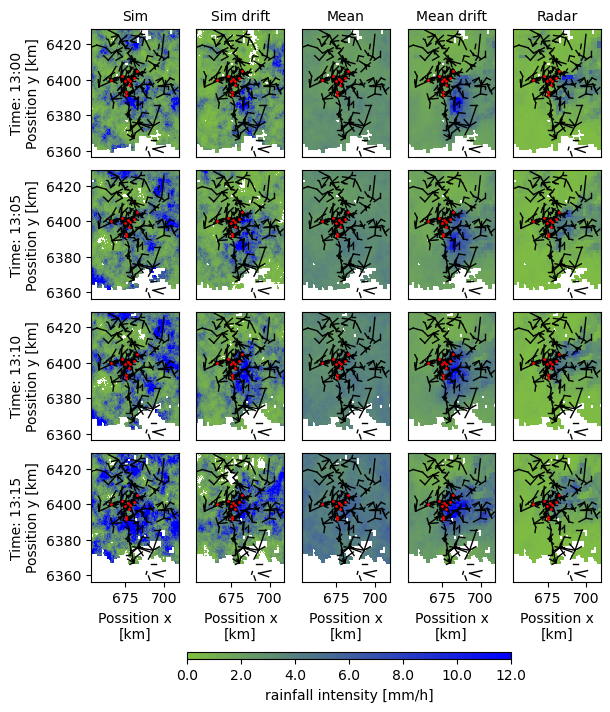

In [63]:
start_maps = '2015-07-25T13:00:00.000000000'
end_maps = '2015-07-25T13:15:00.000000000'

to_mmh = 12

vmax = 12
n_col = 5
ra_thrsld = 0.2/12 # sum 5 min
xgrid_ = xgrid/1000 # grid notation to km
ygrid_ = ygrid/1000

X, Y = np.meshgrid(xgrid_, ygrid_)

cmap_colors = [(0, 'white'), 
               (ra_thrsld/vmax, 'white'), # in percentages of colorspan
               (ra_thrsld/vmax, (0.5, 0.75, 0.25)), 
               (1, 'blue')]  # white -> green-yellow mix -> dark blue
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)


n_row = time_iterate.time.sel(time = slice(start_maps, end_maps)).size
fig = plt.figure(figsize =(6, 7))
gs2 = GridSpec(
    n_row, 
    n_col, 
    #wspace=0.01, 
    hspace=0.1, 
    left=0.14, 
    right=0.99, 
    top = 0.96, 
    bottom=0.17
)

ax = []
for t in range(n_row):
    for c in range(n_col):
        i = int(t*n_col + c)
        ax.append(fig.add_subplot(gs2[i]))

for t, time in enumerate(time_iterate.time.sel(time = slice(start_maps, end_maps))):
    # select timestep, closest to rm output
    tt = np.argmax((time_iterate == time_iterate.sel(time = time, method = 'nearest')).values)

    cml_img = ds_rad_proj.sel(time = time).cml_nearest.data.copy()
    ra_img = ds_rad_proj.sel(time = time).rainfall_amount.data.copy()
    rm_img = copula_dereg['field_conditioned'][tt][2].copy()
    rm_img_drift = copula_dereg_drift['field_conditioned'][tt][2].copy()
    rm_img_mean = np.mean(copula_dereg['field_conditioned'][tt], axis = 0).copy()
    rm_img_mean_drift = np.mean(copula_dereg_drift['field_conditioned'][tt], axis = 0).copy()


    # Threshold using radar intensity
    mask = ra_img <= ra_thrsld    
    rm_img = np.ma.masked_where(mask, rm_img)
    rm_img_drift = np.ma.masked_where(mask, rm_img_drift)
    rm_img_mean_drift = np.ma.masked_where(mask, rm_img_mean_drift)
    rm_img_mean = np.ma.masked_where(mask, rm_img_mean)
    ra_img = np.ma.masked_where(mask, ra_img)
    
    ax[t*n_col + 0].pcolor(X, Y, rm_img*to_mmh, vmin = 0, vmax=vmax, cmap = cmap)
    ax[t*n_col + 1].pcolor(X, Y, rm_img_drift*to_mmh, vmin = 0, vmax=vmax, cmap = cmap)
    ax[t*n_col + 2].pcolor(X, Y, rm_img_mean*to_mmh, vmin = 0, vmax=vmax, cmap = cmap)
    ax[t*n_col + 3].pcolor(X, Y, rm_img_mean_drift*to_mmh, vmin = 0, vmax=vmax, cmap = cmap)
    im = ax[t*n_col + 4].pcolor(X, Y, ra_img*to_mmh, vmin = 0, vmax=vmax, cmap = cmap)

    for c in range(n_col):
        for device in ds_cml.obs_id:
            ax[t*n_col + c].plot([xgrid_[device.x_a], xgrid_[device.x_b]], 
                                 [ygrid_[device.y_a], ygrid_[device.y_b]], '-k', linewidth = 1)
              
        for device in ds_gauges.station_id:
            ax[t*n_col + c].plot(xgrid_[device.x], ygrid_[device.y], 'r', marker='o', markersize =1)

# The following code makes panels share x and y ticks
# Turn off x and y ticks
for t in range(n_row-1):
    for c in range(1, n_col):
        ax[t*n_col + c].tick_params(top=False, bottom=False, left=False, 
                                    right=False,labelleft=False, labelbottom=False, 
                                    axis = 'both', which='both')  
# Turn off x ticks
for t in range(n_row-1):
    ax[t*n_col].tick_params(top=False, bottom=False, left=False, 
                                right=False,labelleft=False, labelbottom=False, 
                                axis = 'x', which='both')  
# Turn off y ticks
for c in range(n_col-1):
    ax[(n_row - 1)*n_col + c + 1].tick_params(top=False, bottom=False, left=False, 
                                right=False,labelleft=False, labelbottom=False, 
                                axis = 'y', which='both')  
# Label y-axis:
for t, time in enumerate(time_iterate.time.sel(time = slice(start_maps, end_maps))):
    str_ = 'Time: ' + str(time.dt.strftime('%H:%M').data) + '\nPossition y [km]'
    ax[t*n_col].set_ylabel(str_, fontsize=10)

# Label x-axis:
for c in range(n_col):
    ax[(n_row - 1)*n_col + c ].set_xlabel('Possition x\n[km]', fontsize=10)

# Add colorbar
cbar_ax = fig.add_axes([0.3, 0.06, 0.54, 0.01]) # (left, bottom, width, height)
fig.colorbar(im, cax=cbar_ax, format=tkr.FormatStrFormatter('%.1f'), orientation='horizontal')
cbar_ax.set_xlabel(r'rainfall intensity [mm/h]', fontsize=10)

# Add column titles
ax[0].set_title('Sim', fontsize=10)
ax[1].set_title('Sim drift', fontsize=10)
ax[2].set_title('Mean', fontsize=10)
ax[3].set_title('Mean drift', fontsize=10)
ax[4].set_title('Radar', fontsize=10)


# for i_ in [3, 5, 7]:
#     ax[i_].plot(40, 60, color = 'blue', marker = '^')
#     ax[i_].plot(30, 30, color = 'blue', marker = '^')
#     ax[i_].plot(60, 30, color = 'blue', marker = '^')
    
# Add figure letters
# for i, ax_ in enumerate(ax):
#     label = string.ascii_lowercase[i]  # This will generate labels a, b, c, ...
#     ax_.text(0.04, 0.89, label + ')', transform=ax_.transAxes, 
#              size=10, bbox=dict(facecolor='white', edgecolor='none', pad=1))


# Save figure
plt.savefig('/home/erlend/Downloads/result_openmrg2_maps.png', format = 'png', dpi=600)
